# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Background estimation 


#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective

**Estimate the uncerntainty on the background contamination**, the number of Bi and Tl events, using blind-data.

### Tasks

   * Do a likelihood profile scan to estimate the uncertainties in the number Bi and Tl events

   * Generate m-large simulation experiments with the estimated number of Bi and Tl events and get the distribution of the number of events of Bi, Tl in RoI


## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


In [6]:
nevts_Bi_blind = collpars.nevts_Bi_blind
nevts_Tl_blind = collpars.nevts_Tl_blind
nns            = [nevts_Bi_blind, nevts_Tl_blind]
print(nns)
print('Number events from Blind Data Energy fit : Bi = {:6.2f}, Tl = {:6.2f}.'.format(*nns))

[117.136, 791.882]
Number events from Blind Data Energy fit : Bi = 117.14, Tl = 791.88.


### Parameters of the collaboration - Estimated in previous steps, NBs

## Access the data

In [7]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = '/data/fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
#mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')
datab = pd.read_hdf(dirpath + filename, key = 'data/blind')

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


### Utilities

In [8]:
samples  = ['Bi', 'Tl']
ssamples = [r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbi, mctl]

## Inspect the variables

In [9]:
#pltext.df_inspect(datab, ncolumns = 3)

## Create MC-blind samples

Generate MC sample without events in the blind region.

The function *selection_blind(mc)* returns the selection with the blind events

Plot the energy

In [10]:
sels_blind = [fn.selection_blind(mc) for mc in mcs]
mcs_blind  = [mc[sel] for mc, sel in zip(mcs, sels_blind)]
for i, mc in enumerate(mcs):
    print('number of events {:s}: total {:d} in blind data {:d}'.format(samples[i], len(mcs[i]), len(mcs_blind[i])))

number of events Bi: total 60184 in blind data 53758
number of events Tl: total 687297 in blind data 674815


## Do a Profile Likelihood Scan

We compute the uncertainties usign the log Likelihood scan

The uncertainties on $\mu$, in the gaussian domain, when there are to parameters to fit $\mu, \nu$, are defined as the points where:

$$
-2 \, \mathrm{log} \frac{\mathcal{L}(x | \mu, \hat{\nu}(\mu))}{\mathcal{L}(x | \hat{\mu}, \hat{\nu})} = 2 \left( \mathrm{log}\mathcal{L}(x | \hat{\mu}, \hat{\nu}) -  \mathrm{log}\mathcal{L}(x | \mu, \hat{\nu}(\mu)\right) = 1
$$

Here from simplicity we take $\hat{\nu}(\mu) = \hat{\nu}$.

In [11]:
from collpars import nevts_Bi_blind, nevts_Tl_blind
ns       = (nevts_Bi_blind, nevts_Tl_blind) # number of events in the blind sample
print('Number of blind events [{:6.3f}, {:6.3f}]'.format(*ns))

Number of blind events [117.136, 791.882]


Estimated number of events : 117.14,  791.88, 


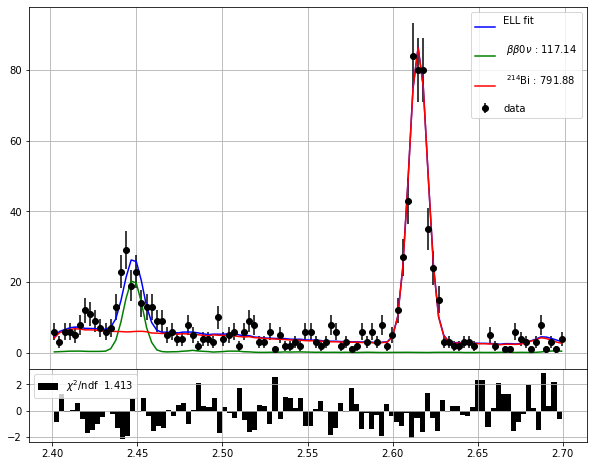

In [12]:
bins     = 100
varname  = 'E'
varrange = erange
# fit_ell: internally generates the composite pdf, calls the fit and returns the fit-result
result, enes, ell, pdfs = fn.fit_ell(datab, mcs_blind, ns, varname = varname, varrange = varrange, bins = bins)
ns_est = result.x
print('Estimated number of events :', *['{:6.2f}, '.format(ni) for ni in ns_est])
# it also plots the histogram, the fit function, and the pdfs samples
fn.plot_fit_ell(enes, ns_est, ell.pdf, pdfs)

Bi range [103.033, 131.895]
Tl range [755.214, 830.255]
uncertainty events Bi blind = 14.431
uncertainty events Tl blind = 37.521


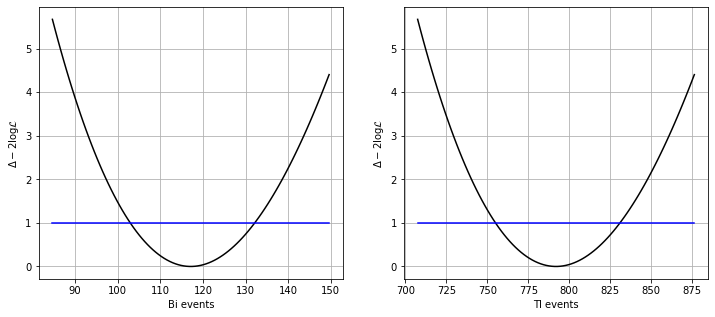

In [13]:
nbi, ntl = ns_est
nbins    = 100 
nsize    = 3

nbis     = np.linspace(nbi - nsize * np.sqrt(nbi), nbi + nsize * np.sqrt(nbi), nbins)
ntls     = np.linspace(ntl - nsize * np.sqrt(ntl), ntl + nsize * np.sqrt(ntl), nbins)

def x_in_dll_range(x, dll, dll0 = 1.):
    dsel = dll <= dll0
    return np.min(x[dsel]), np.max(x[dsel])

llbest   =  -2 * ell.loglike(enes, nbi, ntl)

bi_lls   = [-2 * ell.loglike(enes, ni , ntl) for ni in nbis]
bi_dlls  = np.array(bi_lls)-llbest
bi_range = x_in_dll_range(nbis, bi_dlls)

tl_lls   = [-2 * ell.loglike(enes, ni , ntl) for ni in nbis]
tl_dlls  = np.array(tl_lls)-llbest
tl_range = x_in_dll_range(ntls, tl_dlls)

print('Bi range [{:6.3f}, {:6.3f}]'.format(*bi_range))
print('Tl range [{:6.3f}, {:6.3f}]'.format(*tl_range))

unevts_Bi_blind = (bi_range[1] - bi_range[0])/2.
unevts_Tl_blind = (tl_range[1] - tl_range[0])/2.
print('uncertainty events Bi blind = {:6.3f}'.format(unevts_Bi_blind))
print('uncertainty events Tl blind = {:6.3f}'.format(unevts_Tl_blind))


subplot = pltext.canvas(2)
subplot(1)
plt.grid(); plt.xlabel('Bi events'); plt.ylabel(r'$\Delta -2 \mathrm{log} \mathcal{L}$')
plt.plot(nbis, bi_dlls);
plt.plot(nbis, np.ones(nbins), '-');

subplot(2)
plt.grid(); plt.xlabel('Tl events'); plt.ylabel(r'$\Delta -2 \mathrm{log} \mathcal{L}$')
plt.plot(ntls, tl_dlls);
plt.plot(ntls, np.ones(nbins), '-');

## Compute sigma generating random experiments

Construct an 'Extended Combined PDF' object (see class ExtComPDF in module efit.py). 

This object can generate random events (*rvs* method), provides the PDF (*pdf* method), the extended log likelihood (*loglike*) and even the fit to a best estimate (*best_estimate*).

Internally it uses the module *optimize* of *scipy* ([see](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)). 

Here an example with our previously construced PDFs of each sample.

In [14]:
def experiment(ell, nns, verbose = False):
    if (verbose):
        print('Initial parameters     : {:6.2f}, {:6.2f}'.format(*nns))

    # generate a random experiment
    xs  = ell.rvs()
    # plot the random events
    if (verbose):
        _, edges, _ = pltext.hist(xs, 100, label = 'experiment');

    # fit using the Extended Log Likelihood
    res = ell.best_estimate(xs, *nns)
    # access the information of the 'res' Result Object (see )
    if (verbose):
        print('Fit success? {:s},\nEstimated parameters: {:6.2f}, {:6.2f}'.format(str(res.success), *res.x))

    # overplot the fit result
    ns_est  = res.x
    if (verbose):
        centers = 0.5 * (edges[1:] + edges[:-1])
        scale   = np.sum(ns_est) * (edges[1] - edges[0])
        pdf     = ell.pdf # access to the pdf function inside the composite-PDF object
        plt.plot(centers, scale * pdf(centers, *ns_est), label = 'fit')
        plt.legend();
    return res

Initial parameters     : 117.14, 791.88
Fit success? True,
Estimated parameters: 119.94, 789.07
Fit success? True,
Estimated parameters: 119.94, 789.07


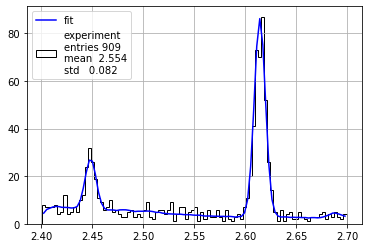

In [15]:
res = experiment(ell, ns, True)
print('Fit success? {:s},\nEstimated parameters: {:6.2f}, {:6.2f}'.format(str(res.success), *res.x))

In [16]:
nexperiments = 100
est_pars     = []
for i in range(nexperiments):
    if (i%100 == 0): print('generating experiment number ', i)
    res = experiment(ell, ns)
    if ((res.success == True) & (res.x[0] != nns[0])): est_pars.append(res.x)

generating experiment number  0


Uncertainty in number of Bi in blind sample 18.054
Uncertainty in number of Tl in blind sample 35.123


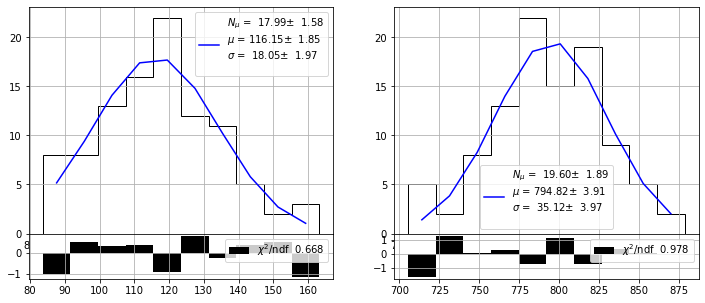

In [17]:
nbis = [x[0] for x in est_pars]
ntls = [x[1] for x in est_pars]

subplot = pltext.canvas(2)
subplot(1)
bipars, _, _, _ = pltext.hfitres(nbis, int(nexperiments/10), fun = 'gaus')
subplot(2)
tlpars, _, _, _ = pltext.hfitres(ntls, int(nexperiments/10), fun = 'gaus')

unevts_Bi_blind_mc = bipars[2]
unevts_Tl_blind_mc = tlpars[2]
print('Uncertainty in number of Bi in blind sample {:6.3f}'.format(unevts_Bi_blind_mc))
print('Uncertainty in number of Tl in blind sample {:6.3f}'.format(unevts_Tl_blind_mc))

Computing the uncertainties in the number of Bkg events in the RoI

In [18]:

unevts_Bi = unevts_Bi_blind/(collpars.eff_Bi_blind)
unevts_Tl = unevts_Bi_blind/(collpars.eff_Tl_blind)

unevts_Bi_RoI = unevts_Bi * collpars.eff_Bi_RoI
unevts_Tl_RoI = unevts_Tl * collpars.eff_Tl_RoI

print('Uncertainty in number of Bi {:6.3f}'.format(unevts_Bi))
print('Uncertainty in number of Tl {:6.3f}'.format(unevts_Tl))

print('Uncertainty in number of Bi {:6.3f}'.format(unevts_Bi_RoI))
print('Uncertainty in number of Tl {:6.3f}'.format(unevts_Tl_RoI))

Uncertainty in number of Bi 18.197
Uncertainty in number of Tl 20.353
Uncertainty in number of Bi  0.282
Uncertainty in number of Tl  0.004


## Write Out

In [19]:
write = True

utotal  = (unevts_Bi      , unevts_Tl)
ublind  = (unevts_Bi_blind, unevts_Tl_blind)
uroi    = (unevts_Bi_RoI  , unevts_Tl_RoI)

if (write):
    of = open('collpars.py', 'a')
    for i, sample in enumerate(samples):
        of.write('unevts_'+sample+'       = {:6.3f}'.format(utotal[i])+'\n')
        of.write('unevts_'+sample+'_blind = {:6.3f}'.format(ublind[i])+'\n')
        of.write('unevts_'+sample+'_RoI   = {:6.3f}'.format(uroi[i])  +'\n')
    of.close()